In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
# 1) ĐỌC VÀ HIỂN THỊ ẢNH GỐC
image_path = "../output_videos/cropped_img.jpg"
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

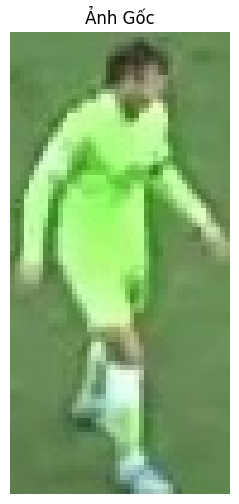

In [4]:
plt.figure(figsize=(4, 6))
plt.imshow(image_rgb)
plt.title("Ảnh Gốc")
plt.axis('off')
plt.show()

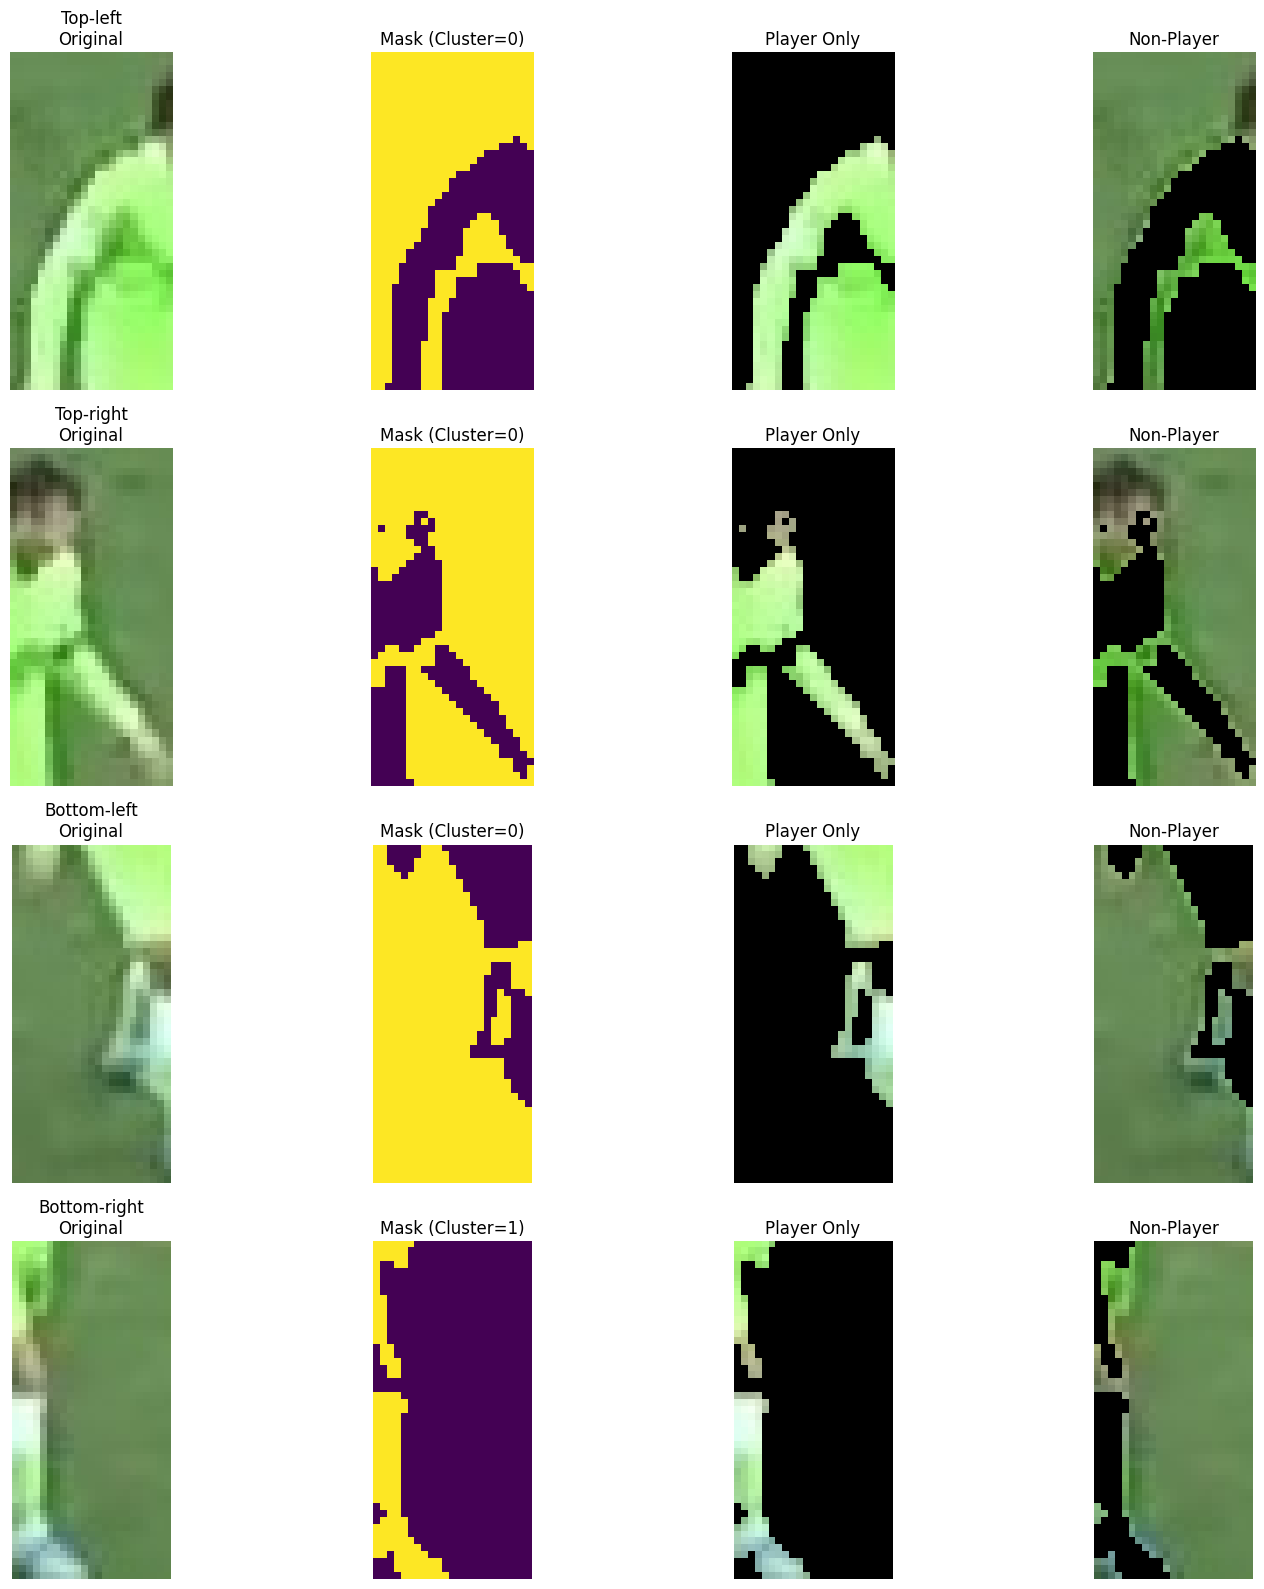

<Figure size 640x480 with 0 Axes>

In [5]:
height, width = image_rgb.shape[:2]
xmin, ymin, xmax, ymax = 0, 0, width, height
mid_x = (xmin + xmax) // 2
mid_y = (ymin + ymax) // 2

tl_img = image_rgb[ymin:mid_y, xmin:mid_x]     
tr_img = image_rgb[ymin:mid_y, mid_x:xmax]     
bl_img = image_rgb[mid_y:ymax, xmin:mid_x]     
br_img = image_rgb[mid_y:ymax, mid_x:xmax]     

sections = [
    ("Top-left", tl_img),
    ("Top-right", tr_img),
    ("Bottom-left", bl_img),
    ("Bottom-right", br_img)
]

def process_region(section_img, n_clusters=2):
    h, w = section_img.shape[:2]
    data = section_img.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(data)
    mask = labels.reshape(h, w)
    
    # Xác định cụm “cầu thủ” dựa trên 4 góc
    corner_clusters = [
        mask[0, 0],
        mask[0, -1],
        mask[-1, 0],
        mask[-1, -1]
    ]
    non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)
    player_cluster = 1 - non_player_cluster
    
    # Binary mask cầu thủ
    binary_mask = (mask == player_cluster).astype(np.uint8)
    # Binary mask nền
    non_player_binary_mask = (mask == non_player_cluster).astype(np.uint8)
    
    # Ảnh chỉ cầu thủ
    player_img = section_img.copy()
    player_img[binary_mask == 0] = [0, 0, 0]
    
    # Ảnh chỉ nền
    non_player_img = section_img.copy()
    non_player_img[non_player_binary_mask == 0] = [0, 0, 0]
    
    player_color = kmeans.cluster_centers_[player_cluster]
    
    return {
        "mask": mask,
        "player_img": player_img,
        "non_player_img": non_player_img,
        "player_color": player_color,
        "player_cluster": player_cluster,
        "non_player_cluster": non_player_cluster
    }

# HIỂN THỊ 4 CỘT: Original, Mask, Player Only, Non-Player
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

for i, (region_name, region_img) in enumerate(sections):
    result = process_region(region_img, n_clusters=2)
    
    # Cột 1: Ảnh gốc
    axes[i, 0].imshow(region_img)
    axes[i, 0].set_title(f"{region_name}\nOriginal")
    axes[i, 0].axis('off')
    
    # Cột 2: Mask KMeans (vàng-tím)
    axes[i, 1].imshow(result["mask"], cmap='viridis')
    axes[i, 1].set_title(f"Mask (Cluster={result['player_cluster']})")
    axes[i, 1].axis('off')
    
    # Cột 3: Ảnh chỉ cầu thủ
    axes[i, 2].imshow(result["player_img"])
    axes[i, 2].set_title("Player Only")
    axes[i, 2].axis('off')
    
    # Cột 4: Ảnh chỉ nền
    axes[i, 3].imshow(result["non_player_img"])
    axes[i, 3].set_title("Non-Player")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()